In [1]:
import os
import json
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

In [2]:
from src.display import plot_boxes, plot_img_seg, plot_image, plot_boxes_instance_masks

In [3]:
PATH = "data/VOCdevkit/VOC2012"

In [4]:
class PascalDataset(Dataset):
    def __init__(self, json_path="data/annotations.json"):
        self.image_path = "data/VOCdevkit/VOC2012/JPEGImages"
        self.seg_path = "data/VOCdevkit/VOC2012/SegmentationObject"

        with open(json_path, "r") as fp:
            data = json.load(fp)
        self.data = data
        
        self.mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
        self.std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    def __len__(self):
        return len(self.data)
    
    def get_plotting_item(self, idx):
        d = self.data[idx]

        img = cv2.imread(os.path.join(self.image_path, d["file_name"]))
        img = img.astype(np.uint8)
        seg_img = cv2.imread(os.path.join(self.seg_path, d["seg_file_name"]), cv2.IMREAD_GRAYSCALE)
        
        seg_img = np.repeat(seg_img[:, :, np.newaxis], 3, axis=2)

        bboxes = np.array([a["bbox"] for a in d["annotations"]])
        class_idxs = np.array([a["class_idx"] for a in d["annotations"]])
        names = [a["class_name"] for a in d["annotations"]]
        
        seg_ids = np.array([a["seg_mask_id"] for a in d["annotations"]], dtype=np.uint8)

        return img, seg_img, bboxes, class_idxs, names, seg_ids
    
    def __getitem__(self, idx):
        img, seg_img, bboxes, class_idxs, _, seg_ids = self.get_plotting_item(idx)

        img = np.transpose(img, (2, 0, 1))
        img = img / 255.0
        img = (img - self.mean) / self.std
        img = torch.from_numpy(img).unsqueeze(0)

        seg_img = torch.from_numpy(seg_img).float().unsqueeze(0)       

        bboxes = torch.from_numpy(bboxes).float().unsqueeze(0)
        class_idxs = torch.from_numpy(class_idxs).float().unsqueeze(0)
        seg_ids = torch.from_numpy(seg_ids).unsqueeze(0)

        return img, seg_img, bboxes, class_idxs, seg_ids

In [5]:
ds = PascalDataset()

In [6]:
ds[0]

(tensor([[[[-1.9124, -2.0837, -2.1179,  ..., -1.4158, -1.4672, -1.5185],
           [-2.1179, -2.1179, -2.1179,  ..., -1.4843, -1.5185, -1.5014],
           [-2.1179, -2.1179, -2.0837,  ..., -1.5870, -1.5870, -1.6042],
           ...,
           [-2.1179, -2.1008, -2.0837,  ..., -2.0494, -2.0494, -2.0494],
           [-2.1179, -1.9809, -2.0494,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.0323, -2.0494,  ..., -1.7240, -1.7069, -1.7412]],
 
          [[-1.6681, -1.8431, -1.8782,  ..., -0.5826, -0.5826, -0.6352],
           [-1.9832, -1.9832, -1.9132,  ..., -0.6352, -0.6527, -0.6352],
           [-1.9132, -1.9132, -1.8431,  ..., -0.6176, -0.6352, -0.6352],
           ...,
           [-2.0357, -2.0182, -2.0182,  ..., -1.8256, -1.8256, -1.8256],
           [-2.0007, -2.0182, -2.0182,  ..., -1.9832, -1.9832, -1.9832],
           [-1.9482, -2.0357, -2.0357,  ..., -1.5630, -1.5455, -1.5630]],
 
          [[-1.2119, -1.3861, -1.4384,  ...,  0.2871,  0.2348,  0.1825],
           [-

In [7]:
ds.data[0]

{'file_name': '2011_001665.jpg',
 'seg_file_name': '2011_001665.png',
 'id': '2011_001665',
 'height': '333',
 'width': '500',
 'annotations': [{'class_name': 'chair',
   'class_idx': 9,
   'bbox': [99, 129, 168, 195],
   'seg_mask_id': 38},
  {'class_name': 'chair',
   'class_idx': 9,
   'bbox': [4, 129, 81, 271],
   'seg_mask_id': 75},
  {'class_name': 'diningtable',
   'class_idx': 11,
   'bbox': [47, 174, 500, 333],
   'seg_mask_id': 113},
  {'class_name': 'chair',
   'class_idx': 9,
   'bbox': [161, 120, 229, 183],
   'seg_mask_id': 14},
  {'class_name': 'diningtable',
   'class_idx': 11,
   'bbox': [59, 124, 252, 196],
   'seg_mask_id': 52},
  {'class_name': 'chair',
   'class_idx': 9,
   'bbox': [1, 209, 55, 333],
   'seg_mask_id': 89},
  {'class_name': 'chair',
   'class_idx': 9,
   'bbox': [264, 103, 294, 154],
   'seg_mask_id': 128},
  {'class_name': 'chair',
   'class_idx': 9,
   'bbox': [445, 92, 489, 181],
   'seg_mask_id': 19},
  {'class_name': 'chair',
   'class_idx': 9,

In [8]:
img, seg_img, bboxes, class_idxs, names, seg_ids = ds.get_plotting_item(1)

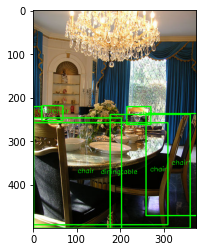

In [9]:
plot_img = plot_boxes(img, bboxes, names)
plot_image(plot_img)

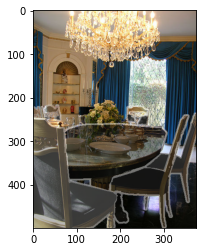

In [10]:
plot_img = plot_img_seg(img, seg_img, (seg_img > 0).astype(np.uint8))
plot_image(plot_img)

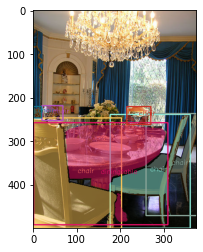

In [11]:
plot_img = plot_boxes_instance_masks(img, seg_img, bboxes, names, seg_ids)
plot_image(plot_img)

In [12]:
import imgaug.augmenters as iaa

crop = iaa.CenterCropToFixedSize(height=320, width=320)

In [13]:
seg_img_i = seg_img[None, :, :]
img_i = img
bboxes_i = bboxes[None, :, :]

In [14]:
images_aug_i, segmaps_aug_i, bboxes_aug_i = crop(image=img_i, segmentation_maps=seg_img_i, bounding_boxes=bboxes_i)

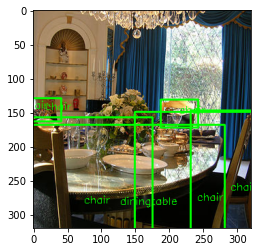

In [15]:
plot_img = plot_boxes(images_aug_i, bboxes_aug_i[0, :, :], names)
plot_image(plot_img)

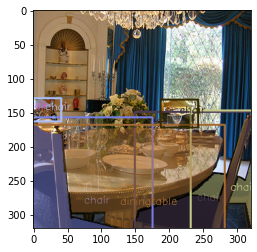

In [16]:
plot_img = plot_boxes_instance_masks(images_aug_i, segmaps_aug_i[0, :, :, :], bboxes_aug_i.tolist()[0], names, seg_ids)
plot_image(plot_img)